# Face Anti-Spoofing Detection
Transfer learning of a MobileNetV2 is used as the classifier, in order to provide fast inference time with respectable precision

In [1]:
!pip install numpy pandas seaborn matplotlib tensorflow h5py pillow scikit-image scikit-learn mlxtend


  Using cached pytz-2024.1-py2.py3-none-any.whl.metadata (22 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
     ---------------------------------------- 0.0/165.5 kB ? eta -:--:--
     --------------------- ----------------- 92.2/165.5 kB 5.1 MB/s eta 0:00:01
     -------------------------------------- 165.5/165.5 kB 3.3 MB/s eta 0:00:00
  Using cached pyparsing-3.1.2-py3-none-any.whl.metadata (5.1 kB)
  Using cached importlib_resources-6.4.0-py3-none-any.whl.metadata (3.9 kB)
   ---------------------------------------- 0.0/11.6 MB ? eta -:--:--
   ---------------------------------------- 0.1/11.6 MB 3.2 MB/s eta 0:00:04
    --------------------------------------- 0.3/11.6 MB 3.5 MB/s eta 0:00:04
   - -------------------------------------- 0.4/11.6 MB 3.3 MB/s eta 0:00:04
   -- ------------------------------------- 0.6/11.6 MB 3.6 MB/s eta 0:00:04
   -- ------------------------------------- 0.8/11.6 MB 3.6 MB/s eta 0:00:03
   --- ----------------------------------

In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

from __future__ import absolute_import, division, print_function, unicode_literals

import os
import glob
import shutil

import cv2
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mimg
import tensorflow as tf

# Import packages for data handling
import h5py
from PIL import Image
from skimage.io import imread
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from mlxtend.plotting import plot_confusion_matrix

# Import deep learning package (tensorflow)
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.applications import mobilenet_v2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Input, Flatten, SeparableConv2D
from tensorflow.keras.layers import GlobalAveragePooling2D, BatchNormalization, Concatenate
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical

color = sns.color_palette()
%matplotlib inline

# Set seed nunmber to all packages
seed_number = 24
np.random.seed(seed_number)
tf.random.set_seed(seed_number)


Configuring directories

In [5]:
# Configuring directories

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory
root = "D:\project"
input_dir = os.path.join(root,"LCC_FASD")
train_dir = os.path.join(input_dir, 'LCC_FASD_training')
val_dir = os.path.join(input_dir, 'LCC_FASD_development')
test_dir = os.path.join(input_dir, 'LCC_FASD_evaluation')

dataset_dir = [dir for dir in sorted(os.listdir(input_dir)) if os.path.isdir(os.path.join(input_dir, dir))]
label_name = [subdir for subdir in sorted(os.listdir(train_dir)) if os.path.isdir(os.path.join(train_dir, subdir))]

# Printing the directory informations
print(f"Main directories\t: {os.listdir(root)}")
print(f"Dataset sub-directories\t: {dataset_dir}")
print(f"Train set directory\t: {label_name}")

Main directories	: ['.ipynb_checkpoints', 'archive.zip', 'celeb-v1-df.zip', 'celeba-dataset.zip', 'CelebA_Spoof.zip.074', 'celeb_df', 'combined_train', 'data1-20240617T160525Z-001.zip', 'extrated', 'face-anti-spoofing-detection-using-mobilenetv2.ipynb', 'kaggle.json', 'LCC_FASD', 'LCC_FASD.rar', 'Liveness Detection 3.ipynb', 'livenessnet.py', 'models', 'msu_mfsd', 'organized_data', 'SDFVD.zip', 'training_log.csv', 'Untitled.ipynb', 'Untitled1.ipynb', 'Untitled10.ipynb', 'Untitled11.ipynb', 'Untitled12.ipynb', 'Untitled2.ipynb', 'Untitled3.ipynb', 'Untitled4.ipynb', 'Untitled5.ipynb', 'Untitled6.ipynb', 'Untitled7.ipynb', 'Untitled8.ipynb', 'Untitled9.ipynb', 'vggface2', 'vggface2-test.zip', 'Xception_CelebDF.pyth']
Dataset sub-directories	: ['LCC_FASD_development', 'LCC_FASD_evaluation', 'LCC_FASD_training']
Train set directory	: ['real', 'spoof']


# Observing the Dataset
Grasping some of the dataset information

In [6]:
dir_dict = {'train': train_dir, 'val': val_dir, 'test': test_dir}
case_count, img_disp, set_length  = {}, {}, {}

for key, val in dir_dict.items():
    case_count[key] = {}
    img_disp[key] = {}
    set_count = 0
    
    for label in label_name:
        label_list = list(sorted(glob.glob(os.path.join(val, label, "*.png"))))
        if len(label_list) == 0:
          continue

        case_count[key][label] = len(label_list)
        set_count += len(label_list)
        
        select_img_id = np.random.randint(len(label_list)-1)
        # print(select_img_id)
        img_disp[key][label] = label_list[select_img_id]
        
    set_length[key] = set_count

case_count_df = pd.DataFrame(case_count)
img_disp_df = pd.DataFrame(img_disp)
print(f"Dataset summary:\n\n{case_count_df}")

Dataset summary:

       train   val  test
real    1323   405   314
spoof   7224  2543  7266


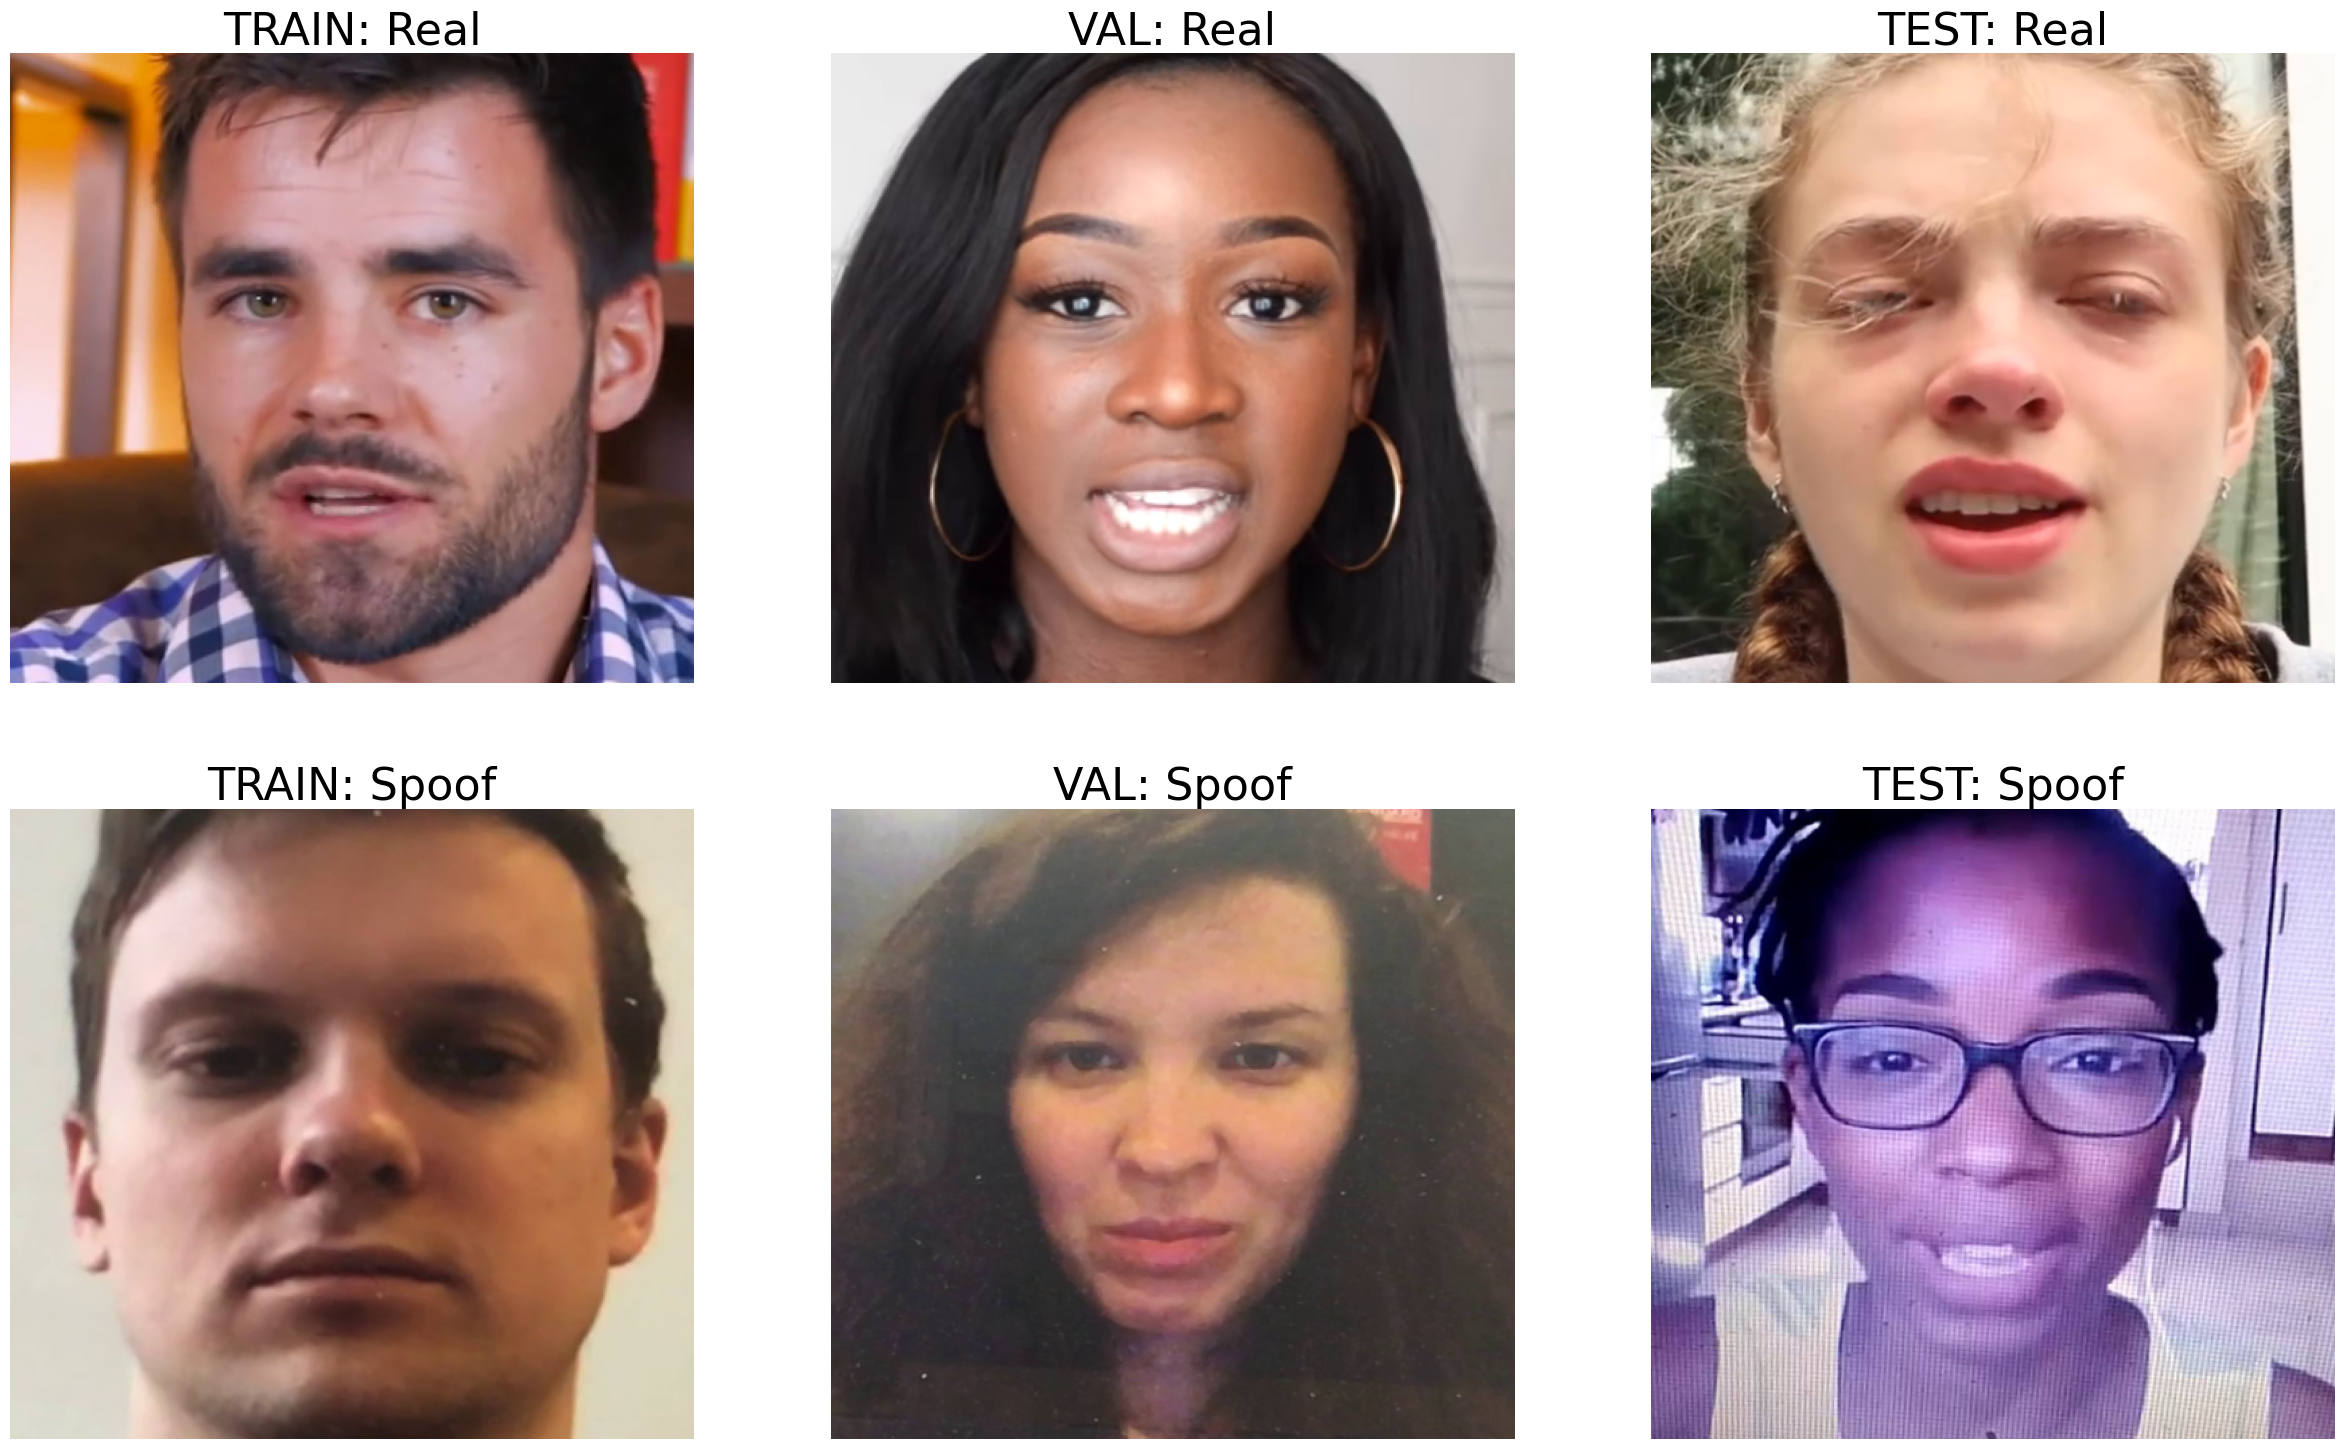

In [7]:
# Visualizing some of the data set
num_classes = len(label_name)
num_dataset = 0
for key, val in set_length.items():
  num_dataset += 1 if val > 0 else 0

f, ax = plt.subplots(num_classes, num_dataset, figsize=(num_dataset*10, 18))

for k in range(num_classes*num_dataset):
    j, i = k//num_dataset, k%num_dataset  # Image indexing
    
    img = imread(img_disp_df.iloc[j, i])
    ax[j, i].imshow(img, cmap='gray')
    ax[j, i].set_title(f"{img_disp_df.columns[i].upper()}: {img_disp_df.index[j].capitalize()}", fontsize=32)
    ax[j, i].axis('off')
    ax[j, i].set_aspect('auto')
plt.show()

# Dataset Problem
Instantiate dataset object for training procedure (e.g., train, val, and test)

In [8]:
# Instantiate data generator for training procedure
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   rotation_range = 20,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.15,
                                   zoom_range = 0.15,
                                   horizontal_flip = True,
                                   fill_mode="nearest")

val_datagen = ImageDataGenerator(rescale = 1./255)
test_datagen = ImageDataGenerator(rescale=1./255) if set_length["test"] > 0 else None

In [9]:
# Define dataset properties
train_batch_size = 32
val_batch_size = 32
img_width = 224
img_height = 224

# Generate dataset for train, val and test
train_gen = train_datagen.flow_from_directory(train_dir,
                                              batch_size = train_batch_size,
                                              class_mode = 'binary',
                                              target_size = (img_width, img_height),
                                              seed = seed_number)

val_gen = val_datagen.flow_from_directory(val_dir,
                                          batch_size = val_batch_size,
                                          class_mode = 'binary',
                                          target_size = (img_width, img_height),
                                          seed = seed_number)

if test_datagen is not None:
  test_gen = test_datagen.flow_from_directory(test_dir,
                                              batch_size = 1,
                                              class_mode = 'binary',
                                              target_size = (img_width, img_height),
                                              seed = seed_number,
                                              shuffle=False)
else:
  test_gen = None

Found 8547 images belonging to 2 classes.
Found 2948 images belonging to 2 classes.
Found 7580 images belonging to 2 classes.


In [10]:
# Displaying the dataset generator information
print(f'Train set batch shape\t: {next(train_gen)[0].shape}')
print(f'Val set batch shape\t: {next(val_gen)[0].shape}')
print(f'Test set batch shape\t: {next(test_gen)[0].shape}') if test_gen is not None else None

Train set batch shape	: (32, 224, 224, 3)
Val set batch shape	: (32, 224, 224, 3)
Test set batch shape	: (1, 224, 224, 3)


# Generate Model
Using a pre-trained MobileNet-v2 model, provided by tensorflow

In [11]:
# Don't forget to turn on the Internet to download the respective pre-trained weights!
pretrain_net = mobilenet_v2.MobileNetV2(input_shape = (img_width, img_height, 3),
                                        include_top = False,
                                        weights = 'imagenet')

# load_param_path = '../input/mobilenet_v2/xception_weights_tf_dim_ordering_tf_kernels_notop.h5'  # Offline alternative
# pretrain_net.load_weights(load_param_path)  # Manually load the weights from the input directory

# ------ Freezing layer(s) up to a specific layer ------
freeze_before = None  #"block_16_expand"  # use None to train, use "all" to freeze all the layers

if freeze_before:
    for layer in pretrain_net.layers:
        if layer.name == freeze_before:
            break
        else:
            layer.trainable = False


In [12]:
# Adding extra layer for our problem
x = pretrain_net.output
x = Conv2D(32, (3, 3), activation='relu')(x)
x = Dropout(rate=0.2, name='extra_dropout1')(x)
x = GlobalAveragePooling2D()(x)
# x = Dense(units=128, activation='relu', name='extra_fc1')(x)
# x = Dropout(rate=0.2, name='extra_dropout1')(x)
x = Dense(1, activation='sigmoid', name='classifier')(x)

model = Model(inputs=pretrain_net.input, outputs=x, name='mobilenetv2_spoof')
print(model.summary())

# Notice: Unhide the OUTPUT!

Model: "mobilenetv2_spoof"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                                 

# Perform Training
Define the training procedure

In [16]:
train_id = "lcc-train04b-weight_all"  # ID of the training procedure
num_epochs = 15  # Set the number of epochs to train
learning_rate = 5e-5  # Set the learning rate to use

print(f"Training config of '{train_id}'...")
print(f"Number of epoch\t: {num_epochs}")
print(f"Initial LR\t: {learning_rate}")

model.compile(optimizer = Adam(learning_rate=learning_rate),
              loss = 'binary_crossentropy',
              metrics = ['acc'])

# Define model callback
save_dir = os.path.join("./", train_id)
if not os.path.isdir(save_dir):
  os.makedirs(save_dir)

cont_filepath = "mobilenetv2-epoch_{epoch:02d}.hdf5"
cont_checkpoint = ModelCheckpoint(os.path.join(save_dir, cont_filepath))

best_filepath = "mobilenetv2-best.hdf5"
best_checkpoint = ModelCheckpoint(os.path.join(save_dir, best_filepath),
                                  save_best_only=True,
                                  save_weights_only=True)

# Instantiate tensorboard
log_dir = os.path.join(save_dir, "logs")
use_tensorboard = TensorBoard(log_dir=log_dir,
                              histogram_freq=1,
                              update_freq="batch")

# Instantiate learning rate scheduler with Plateau method
plateau_scheduler = ReduceLROnPlateau(factor=0.2, patience=3, verbose=1, 
                                      min_delta= 0.005, min_lr=5e-7)

# Displaying tensorboard
#%tensorboard --logdir log_dir

# Define class weight
train_length = len(train_gen.classes)
weight0 = train_length / case_count_df['train'][label_name[0]] * (1 / len(label_name))
weight1 = train_length / case_count_df['train'][label_name[1]] * (1 / len(label_name))
class_weight = {0: weight0, 1: weight1}

print(f"Class weight\t: {class_weight}")


Training config of 'lcc-train04b-weight_all'...
Number of epoch	: 15
Initial LR	: 5e-05
Class weight	: {0: 3.2301587301587302, 1: 0.5915697674418605}


Start training!

In [17]:
# Resume training (UNCOMMENT to use!)
# checkpoint_path = "mobilenetv2-epoch_01"
# model.load(os.path.join(savedir, checkpoint_path))

# Perform training
history = model.fit(train_gen,
                    epochs = num_epochs,
                    steps_per_epoch = set_length['train'] // train_batch_size,
                    validation_data = val_gen,
                    validation_steps = 1,
                    callbacks = [best_checkpoint,
                                 cont_checkpoint,
                                 plateau_scheduler],
                    class_weight=class_weight)

history_df = pd.DataFrame.from_dict(history.history)
history_df.to_csv(os.path.join(save_dir, "history.csv"), index=False)

# Notice: Unhide the OUTPUT!

Epoch 1/15
267/267 [==============================] - 361s 1s/step - loss: 0.2478 - acc: 0.8928 - val_loss: 0.2446 - val_acc: 0.8750 - lr: 5.0000e-05
Epoch 2/15
267/267 [==============================] - 169s 626ms/step - loss: 0.0794 - acc: 0.9675 - val_loss: 0.6177 - val_acc: 0.8438 - lr: 5.0000e-05
Epoch 3/15
267/267 [==============================] - 164s 613ms/step - loss: 0.0535 - acc: 0.9769 - val_loss: 0.4132 - val_acc: 0.9375 - lr: 5.0000e-05
Epoch 4/15
267/267 [==============================] - ETA: 0s - loss: 0.0397 - acc: 0.9837
Epoch 4: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.
267/267 [==============================] - 163s 610ms/step - loss: 0.0397 - acc: 0.9837 - val_loss: 1.1642 - val_acc: 0.9062 - lr: 5.0000e-05
Epoch 5/15
267/267 [==============================] - 164s 612ms/step - loss: 0.0286 - acc: 0.9905 - val_loss: 7.5880e-05 - val_acc: 1.0000 - lr: 1.0000e-05
Epoch 6/15
267/267 [==============================] - 164s 611ms/step - loss: 

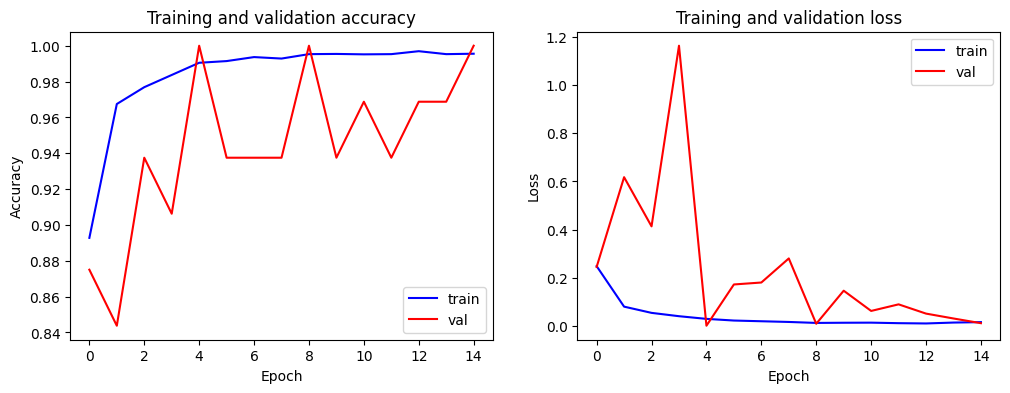

In [18]:
# Plotting the train results
train_accuracy = history.history['acc']
val_accuracy = history.history['val_acc']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(train_accuracy))
plt.figure(figsize=(12,4))

# Plotting the accuracy
plt.subplot(1,2,1)
plt.plot(epochs, train_accuracy, 'b', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['train', 'val'], loc='lower right')

# Plotting the loss
plt.subplot(1,2,2)
plt.plot(epochs, train_loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train', 'val'], loc='upper right')

plt.show()

# Results evaluation
Use this section to evaluate the model performance on the Test set.

In [19]:
# Test set accuracy and loss
test_scores = model.evaluate(test_gen, steps=set_length['test'])
print("Test results Accuracy: {0:.2f}% and Loss: {0:.2f}".format(test_scores[1]*100, test_scores[0]))

# Calculate prediction
threshold = 0.5  # Define the sigmoid threshold for True or False
y_pred_value = np.squeeze(model.predict(test_gen, steps=set_length['test'], verbose=1))

y_pred = np.zeros(y_pred_value.shape).astype(np.int32)  # Sigmoid
y_pred[y_pred_value > threshold] = 1

# y_pred = np.argmax(y_pred_value, axis=-1).astype(np.int32)  # Softmax

y_true = test_gen.classes

# Sanity check on the y_pred and y_true value
print(f"Label\t\t: {y_true[:10]}")
print(f"Prediction\t: {y_pred[:10]}")

7580/7580 [==============================] - 270s 36ms/step - loss: 0.0906 - acc: 0.9764
Test results Accuracy: 97.64% and Loss: 97.64
7580/7580 [==============================] - 141s 18ms/step
Label		: [0 0 0 0 0 0 0 0 0 0]
Prediction	: [0 0 0 0 0 1 0 0 0 0]


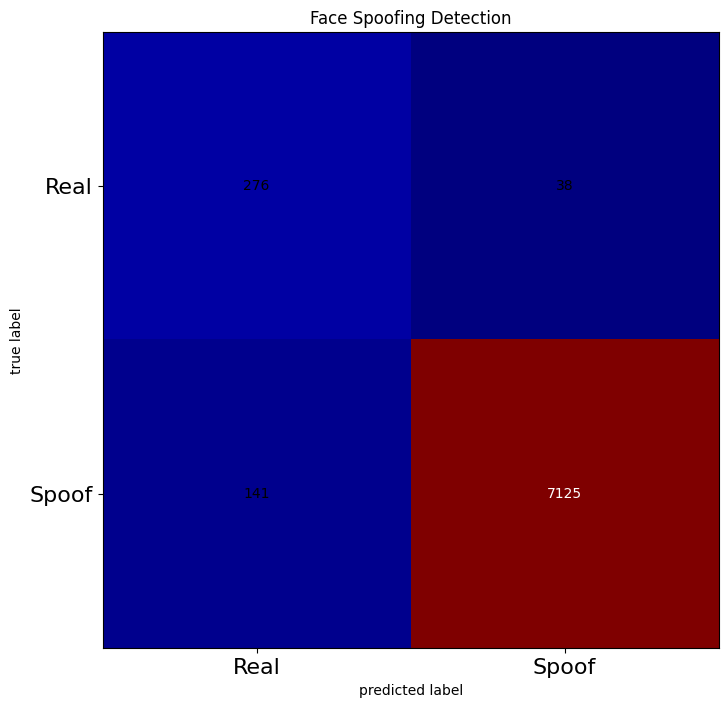

Report Summary:
Precision	: 99.47%
Recall		: 98.06%
F1 Score	: 98.76%

Notes: 
True labels	: Spoof
False labels	: Real


In [20]:
# Confusion matrix result
confusion_matrix_result = confusion_matrix(y_true, y_pred)
plot_confusion_matrix(confusion_matrix_result,
                      figsize=(12,8),
                      hide_ticks=True,
                      cmap=plt.cm.jet)
plt.title("Face Spoofing Detection")
plt.xticks(range(2), ['Real', 'Spoof'], fontsize=16)
plt.yticks(range(2), ['Real', 'Spoof'], fontsize=16)
plt.show()

# Precision and Recall metrics
tn, fp, fn, tp = confusion_matrix_result.ravel()
precision = tp / (tp+fp)
recall = tp / (tp+fn)
f1_score = 2 * precision * recall / (precision+recall)

print("Report Summary:")
print("Precision\t: {:.2f}%".format(precision*100))
print("Recall\t\t: {:.2f}%".format(recall*100))
print("F1 Score\t: {:.2f}%".format(f1_score*100))

print("\nNotes: ")
print("True labels\t: Spoof")
print("False labels\t: Real")
